In [10]:
import pandas as pd
#read the csv /Users/simongu/Documents/Library_QPA/QPA/es.c.0-20100606-20251116.et.ohlcv-1m.csv
df=pd.read_csv("/Users/simongu/Documents/Library_QPA/QPA/es.c.0-20100606-20251116.et.ohlcv-1m.csv")
df.head()
#setting the index to the ET_datetime
df.set_index('ET_datetime', inplace=True)
df.head()


,ts_event,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
ET_datetime,,,,,,,,,,
2010-06-06 20:00:00-04:00,2010-06-07 00:00:00+00:00,33,1,6640,1061.25,1061.75,1061.25,1061.25,206,ES.c.0
2010-06-06 20:01:00-04:00,2010-06-07 00:01:00+00:00,33,1,6640,1061.25,1062.00,1061.25,1062.00,495,ES.c.0
2010-06-06 20:02:00-04:00,2010-06-07 00:02:00+00:00,33,1,6640,1061.75,1062.00,1061.50,1061.50,476,ES.c.0
2010-06-06 20:03:00-04:00,2010-06-07 00:03:00+00:00,33,1,6640,1061.50,1061.50,1061.00,1061.00,270,ES.c.0
2010-06-06 20:04:00-04:00,2010-06-07 00:04:00+00:00,33,1,6640,1061.25,1062.25,1061.00,1062.25,349,ES.c.0


,ts_event,rtype,publisher_id,instrument_id,open,high,low,close,volume,symbol
ET_datetime,,,,,,,,,,
2010-06-06 20:00:00-04:00,2010-06-07 00:00:00+00:00,33,1,6640,1061.25,1061.75,1061.25,1061.25,206,ES.c.0
2010-06-06 20:01:00-04:00,2010-06-07 00:01:00+00:00,33,1,6640,1061.25,1062.00,1061.25,1062.00,495,ES.c.0
2010-06-06 20:02:00-04:00,2010-06-07 00:02:00+00:00,33,1,6640,1061.75,1062.00,1061.50,1061.50,476,ES.c.0
2010-06-06 20:03:00-04:00,2010-06-07 00:03:00+00:00,33,1,6640,1061.50,1061.50,1061.00,1061.00,270,ES.c.0
2010-06-06 20:04:00-04:00,2010-06-07 00:04:00+00:00,33,1,6640,1061.25,1062.25,1061.00,1062.25,349,ES.c.0


In [5]:
import pandas as pd
import numpy as np

def get_valid_b1_days(df):
    """
    Input: df (1-minute ES Data, Index is Eastern Time)
    Output: DataFrame containing only the Days where a trade triggered.
    """
    
    # -------------------------------------------------------
    # 1. Prepare the "Macro" Data (Daily Context) - NO LEAKS
    # -------------------------------------------------------
    # We use 09:30 to 16:15 to calculate the "True" Daily Range for ADR
    df_rth = df.between_time('09:30', '16:15')
    
    daily = df_rth.resample('1D').agg({
        'high': 'max',
        'low': 'min',
        'close': 'last'  # 16:15 Settlement Price
    }).dropna()

    # Calculate daily range first
    daily['daily_range'] = daily['high'] - daily['low']
    
    # LEAK FIX 1: Shift logic so ADR only uses PAST data
    # "Shift 1" moves yesterday's data to today's row, then rolling uses only past data
    daily['ADR_21'] = daily['daily_range'].shift(1).rolling(21).mean()
    
    # Previous Close (for Gap Calculation)
    daily['prev_close'] = daily['close'].shift(1)

    # -------------------------------------------------------
    # 2. Prepare the "Micro" Data (The 9:30 B1 Bar) - SAFE MERGE
    # -------------------------------------------------------
    # Resample 1-min to 5-min, taking the first bar of the day
    df_5min = df.resample('5min', closed='left', label='left').agg({
        'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'
    }).dropna()
    
    # Grab only the 09:30 bar
    b1 = df_5min.at_time('09:30').copy()
    
    # Map Daily Context to B1 (Align by Date)
    b1['date'] = b1.index.normalize()
    daily['date'] = daily.index.normalize()
    
    # LEAK FIX 2: Safe Merge (Reset Index -> Merge -> Set Index)
    # Store the original index name
    index_name = b1.index.name if b1.index.name else 'ET_datetime'
    b1 = b1.reset_index()  # Reset to keep timestamp as a column
    b1 = b1.merge(daily[['ADR_21', 'prev_close', 'date']], on='date', how='left')
    b1 = b1.set_index(index_name)  # Restore the timestamp index safely

    # -------------------------------------------------------
    # 3. Calculate Strategy Metrics - NO AVG LEAK
    # -------------------------------------------------------
    
    # GAP Logic: (Open - PrevClose) / ADR
    b1['Gap_Pts'] = b1['open'] - b1['prev_close']
    b1['Gap_Pct_ADR'] = (b1['Gap_Pts'].abs() / b1['ADR_21']) * 100 # In percent
    
    # BAR Logic
    b1['Range'] = b1['high'] - b1['low']
    b1['Body'] = (b1['close'] - b1['open']).abs()
    b1['Body_Pct'] = b1['Body'] / b1['Range']
    b1['IBS'] = (b1['close'] - b1['low']) / b1['Range']
    
    # LEAK FIX 3: Shift ABR so we compare Today vs HISTORY (not Today vs Today+History)
    # "Shift 1" ensures we only use past data to calculate the average
    b1['ABR_8'] = b1['Range'].shift(1).rolling(8).mean()

    # -------------------------------------------------------
    # 4. Apply the "Screenshot" Filters
    # -------------------------------------------------------
    
    # A. Background Filter: Gap is 11% to 60% of ADR
    f_gap = b1['Gap_Pct_ADR'].between(11.0, 60.0)
    
    # B. Signal Filter: Body is >= 50% of Range
    f_trend = b1['Body_Pct'] >= 0.50
    
    # C. Climactic Filter: Range is <= 250% of ABR(8)
    f_climactic = b1['Range'] <= (2.5 * b1['ABR_8'])
    
    # D. Direction Logic
    # Bull: Green Candle + IBS > 0.69
    f_bull = (b1['close'] > b1['open']) & (b1['IBS'] > 0.69)
    # Bear: Red Candle + IBS < 0.31
    f_bear = (b1['close'] < b1['open']) & (b1['IBS'] < 0.31)

    # -------------------------------------------------------
    # 5. Return the Filtered List
    # -------------------------------------------------------
    
    # Identify valid Longs and Shorts
    valid_longs = f_gap & f_trend & f_climactic & f_bull
    valid_shorts = f_gap & f_trend & f_climactic & f_bear
    
    # Create a result dataframe
    results = b1[valid_longs | valid_shorts].copy()
    
    # Label the direction
    results['Direction'] = np.where(results.index.isin(b1[valid_longs].index), 'LONG', 'SHORT')
    
    # Select clean columns to display
    cols = ['Direction', 'open', 'close', 'Gap_Pct_ADR', 'IBS', 'Range', 'ABR_8']
    print(results[['open', 'close', 'high', 'low', 'Range']].head())
    return results[cols]
df.index = pd.to_datetime(df.index, utc=True)

# 2. Convert the whole index to Eastern Time
# This turns it into the proper DatetimeIndex required by .between_time()
df.index = df.index.tz_convert('America/New_York')

# 3. Verify it worked (It must say datetime64, NOT object)
print("Index Type:", df.index.dtype)

# --- NOW RUN YOUR STRATEGY ---
days_list = get_valid_b1_days(df)
print(days_list)



Index Type: datetime64[ns, America/New_York]
                              open    close     high      low  Range
ET_datetime                                                         
2010-07-13 09:30:00-04:00  1086.25  1085.25  1086.75  1085.00   1.75
2010-07-16 09:30:00-04:00  1085.75  1083.75  1086.50  1083.25   3.25
2010-07-21 09:30:00-04:00  1085.00  1084.00  1085.50  1083.75   1.75
2010-07-28 09:30:00-04:00  1108.00  1109.75  1109.75  1107.75   2.00
2010-08-09 09:30:00-04:00  1123.75  1122.50  1124.25  1122.00   2.25
                          Direction     open    close  Gap_Pct_ADR       IBS  \
ET_datetime                                                                    
2010-07-13 09:30:00-04:00     SHORT  1086.25  1085.25    55.739881  0.142857   
2010-07-16 09:30:00-04:00     SHORT  1085.75  1083.75    25.819672  0.153846   
2010-07-21 09:30:00-04:00     SHORT  1085.00  1084.00    24.481865  0.142857   
2010-07-28 09:30:00-04:00      LONG  1108.00  1109.75    16.416938  1.00

In [6]:
#find the correctness of direction prediction
#                          Direction     open    close  Gap_Pct_ADR       IBS  \
#ET_datetime                                                                    
#2010-07-13 09:30:00-04:00     SHORT  1086.25  1085.25    55.739881  0.142857   
#2010-07-16 09:30:00-04:00     SHORT  1085.75  1083.75    25.819672  0.153846   




In [7]:
import pandas as pd
import numpy as np

def get_valid_b1_days(df):
    """
    Input: df (1-minute ES Data, Index is Eastern Time)
    Output: DataFrame containing only the Days where a trade triggered.
    """
    
    # -------------------------------------------------------
    # 1. Prepare the "Macro" Data (Daily Context - RTH ONLY)
    # -------------------------------------------------------
    # Use 09:30 to 16:15 for daily range calculations
    df_rth = df.between_time('09:30', '16:15')
    
    # Create a DataFrame indexed by valid Trading Days only
    # .dropna() removes weekends and holidays where no RTH data exists
    daily = df_rth.resample('1D').agg({
        'high': 'max',
        'low': 'min',
        'close': 'last'  # 16:15 Settlement Price
    }).dropna()

    # Calculate daily range
    daily['daily_range'] = daily['high'] - daily['low']
    
    # ADR: Shift 1 so we use yesterday's 21-day average
    daily['ADR_21'] = daily['daily_range'].shift(1).rolling(21).mean()
    
    # Previous Close (for Gap Calculation)
    daily['prev_close'] = daily['close'].shift(1)
    
    # Normalize daily index to midnight for easy merging
    daily['date_normalized'] = daily.index.normalize()

    # -------------------------------------------------------
    # 2. Calculate ABR(8) and Align to RTH Sequence
    # -------------------------------------------------------
    
    # Resample to 5-min bars
    df_5min = df.resample('5min', closed='left', label='left').agg({
        'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last'
    }).dropna()
    
    # Calculate Range for ALL 5-min bars
    df_5min['Bar_Range'] = df_5min['high'] - df_5min['low']
    
    # Calculate Rolling 8 Period Average
    df_5min['Rolling_ABR_8'] = df_5min['Bar_Range'].rolling(8).mean()

    # Extract ONLY the 16:10 bars (which cover 16:10:00 -> 16:14:59)
    last_bars = df_5min.at_time('16:10').copy()
    last_bars['date_normalized'] = last_bars.index.normalize()
    
    # Create a lookup Series: { Date : 16:10_ABR }
    # We set the index to the normalized date to map it to our 'daily' DF
    abr_map = last_bars.set_index('date_normalized')['Rolling_ABR_8']
    
    # --- CRITICAL STEP: Enforce RTH Sequence ---
    # We map the ABR values onto the 'daily' DataFrame.
    # Because 'daily' only contains valid Trading Days, this aligns the data.
    daily['EOD_ABR_Today'] = daily['date_normalized'].map(abr_map)
    
    # Now we SHIFT(1) on the 'daily' DataFrame.
    # This guarantees that for Monday, we grab the previous row in 'daily' (Friday).
    # It skips weekends/holidays because they don't exist as rows in 'daily'.
    daily['ABR_8_From_Prev_RTH'] = daily['EOD_ABR_Today'].shift(1)

    # -------------------------------------------------------
    # 3. Prepare the "Micro" Data (The 9:30 B1 Bar)
    # -------------------------------------------------------
    b1 = df_5min.at_time('09:30').copy()
    b1['date_normalized'] = b1.index.normalize()
    
    if not b1.index.name:
        b1.index.name = 'ET_datetime'
    index_name = b1.index.name
    b1 = b1.reset_index()
    
    # Merge all Context from the 'daily' master list
    # This brings in ADR_21, prev_close, AND our correctly shifted ABR
    b1 = b1.merge(daily[['ADR_21', 'prev_close', 'ABR_8_From_Prev_RTH', 'date_normalized']], 
                  on='date_normalized', 
                  how='left')
    
    b1 = b1.set_index(index_name)

    # -------------------------------------------------------
    # 4. Calculate Strategy Metrics
    # -------------------------------------------------------
    
    # GAP Logic
    b1['Gap_Pts'] = b1['open'] - b1['prev_close']
    b1['Gap_Pct_ADR'] = (b1['Gap_Pts'].abs() / b1['ADR_21']) * 100 
    
    # BAR Logic
    b1['Range'] = b1['high'] - b1['low']
    b1['Body'] = (b1['close'] - b1['open']).abs()
    b1['Body_Pct'] = b1['Body'] / b1['Range']
    b1['IBS'] = (b1['close'] - b1['low']) / b1['Range']
    
    # -------------------------------------------------------
    # 5. Apply Filters
    # -------------------------------------------------------
    
    # A. Background Filter
    f_gap = b1['Gap_Pct_ADR'].between(11.0, 60.0)
    
    # B. Signal Filter
    f_trend = b1['Body_Pct'] >= 0.50
    
    # C. Climactic Filter: Range <= 250% of (Previous RTH 16:10 ABR)
    f_climactic = b1['Range'] <= (2.5 * b1['ABR_8_From_Prev_RTH'])
    
    # D. Direction Logic
    f_bull = (b1['close'] > b1['open']) & (b1['IBS'] > 0.69)
    f_bear = (b1['close'] < b1['open']) & (b1['IBS'] < 0.31)

    # -------------------------------------------------------
    # 6. Return Results
    # -------------------------------------------------------
    
    valid_longs = f_gap & f_trend & f_climactic & f_bull
    valid_shorts = f_gap & f_trend & f_climactic & f_bear
    
    results = b1[valid_longs | valid_shorts].copy()
    results['Direction'] = np.where(results.index.isin(b1[valid_longs].index), 'LONG', 'SHORT')
    
    cols = ['Direction', 'open', 'close', 'Gap_Pct_ADR', 'IBS', 'Range', 'ABR_8_From_Prev_RTH']
    
    return results[cols]

# --- USAGE SETUP (Make sure your df is loaded) ---
df.index = pd.to_datetime(df.index, utc=True)
df.index = df.index.tz_convert('America/New_York')
days_list = get_valid_b1_days(df)
print(days_list)

                          Direction     open    close  Gap_Pct_ADR       IBS  \
ET_datetime                                                                    
2010-07-13 09:30:00-04:00     SHORT  1086.25  1085.25    55.739881  0.142857   
2010-07-16 09:30:00-04:00     SHORT  1085.75  1083.75    25.819672  0.153846   
2010-07-21 09:30:00-04:00     SHORT  1085.00  1084.00    24.481865  0.142857   
2010-07-28 09:30:00-04:00      LONG  1108.00  1109.75    16.416938  1.000000   
2010-08-09 09:30:00-04:00     SHORT  1123.75  1122.50    25.301205  0.222222   
...                             ...      ...      ...          ...       ...   
2025-10-31 09:30:00-04:00     SHORT  6902.00  6893.00    40.235542  0.155556   
2025-11-03 09:30:00-05:00     SHORT  6908.25  6898.25    53.500867  0.100000   
2025-11-07 09:30:00-05:00     SHORT  6723.50  6706.75    43.913114  0.042254   
2025-11-13 09:30:00-05:00     SHORT  6847.25  6842.50    46.061049  0.289474   
2025-11-17 09:30:00-05:00      LONG  673

=== Strategy Performance (R units) ===
n_trading_days           : 5643
n_trades                 : 651
win_rate                 : 0.3932411674347158
expectancy_R_per_trade   : -0.00737327188940092
avg_R_per_day            : -0.0008506113769271664
ann_sharpe               : -0.039202517536745154
max_drawdown_R           : -33.0
trades_per_year          : 29.07177033492823
avg_trade_duration_min   : 34.85099846390169

Number of trades: 651
First few trades:


,trade_date,direction,entry_time,exit_time,entry_price,exit_price,R,pnl_pts,pnl_R,target_mult,abr,b1_range,b2_follow_through,duration_min,exit_reason
0,2010-07-16 00:00:00-04:00,SHORT,2010-07-16 09:39:00-04:00,2010-07-16 09:55:00-04:00,1083.00,1075.50,3.75,7.5,2.0,2.0,3.46875,3.25,good,16.0,target
1,2010-07-21 00:00:00-04:00,SHORT,2010-07-21 09:35:00-04:00,2010-07-21 09:49:00-04:00,1083.50,1079.00,2.25,4.5,2.0,2.0,1.90625,1.75,good,14.0,target
2,2010-07-28 00:00:00-04:00,LONG,2010-07-28 09:35:00-04:00,2010-07-28 09:47:00-04:00,1110.00,1107.50,2.50,-2.5,-1.0,2.0,1.34375,2.00,good,12.0,stop
3,2010-08-09 00:00:00-04:00,SHORT,2010-08-09 09:35:00-04:00,2010-08-09 10:10:00-04:00,1121.75,1121.75,2.75,0.0,0.0,2.0,1.65625,2.25,good,35.0,stop
4,2010-08-13 00:00:00-04:00,LONG,2010-08-13 09:36:00-04:00,2010-08-13 11:36:00-04:00,1081.75,1076.75,5.00,-5.0,-1.0,1.0,1.87500,4.50,poor,120.0,stop


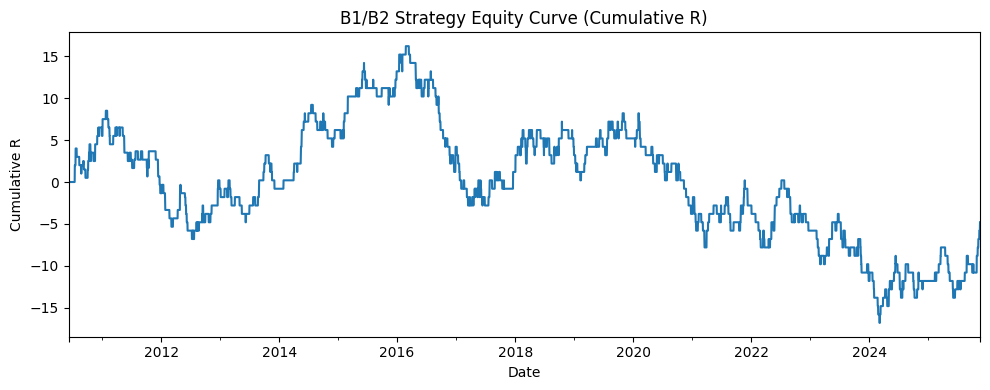

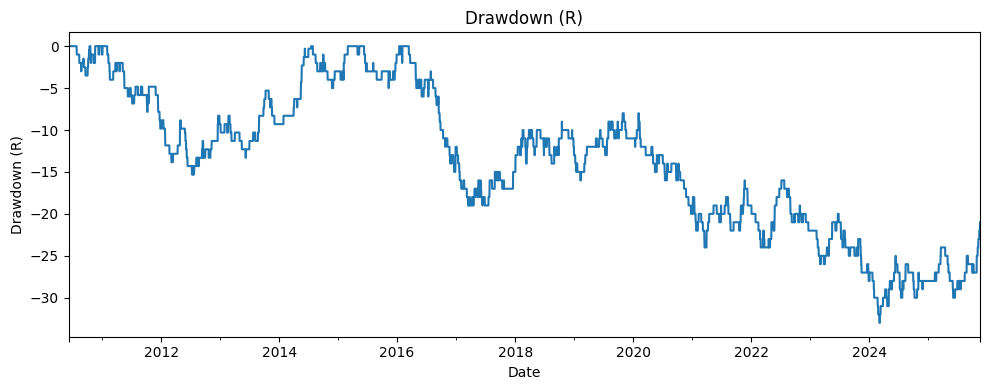

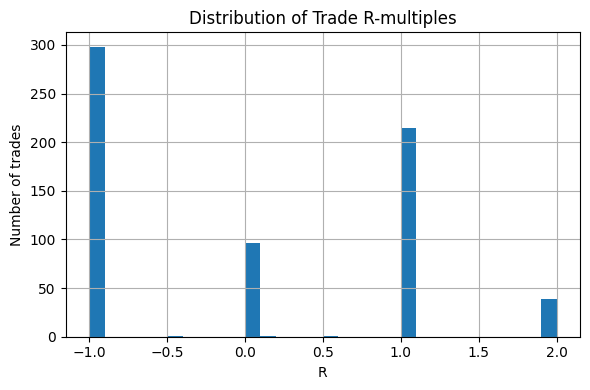

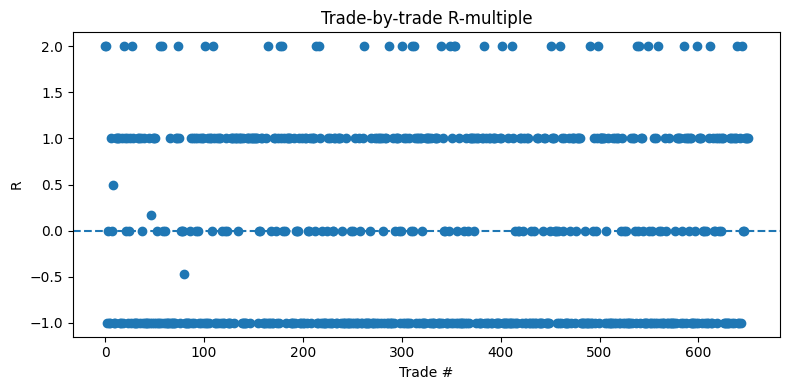

In [9]:
def backtest_b1_b2_strategy(
    df_1min: pd.DataFrame,
    setups: pd.DataFrame,
    tick_size: float = 0.25,
    rth_start: str = "09:30",
    rth_end: str = "16:15",
):
    """
    Backtest the B1/B2 intraday strategy.

    Change vs previous version:
    - B1/ABR decides whether 2R is even possible.
    - Before B2 closes:
        * If B1_range <= 1.5 * ABR: target is 2R.
        * Else: target is 1R.
    - After B2 closes:
        * If B1_range > 1.5 * ABR: target stays 1R.
        * If B1_range <= 1.5 * ABR:
            - If B2 follow-through is good (same color): keep 2R.
            - If B2 follow-through is poor (opposite color): downgrade open and future trades to 1R.
    """

    # If no data or no setups, return empty structures
    if df_1min.empty or setups.empty:
        trades = pd.DataFrame(
            columns=[
                "trade_date",
                "direction",
                "entry_time",
                "exit_time",
                "entry_price",
                "exit_price",
                "R",
                "pnl_pts",
                "pnl_R",
                "target_mult",
                "abr",
                "b1_range",
                "b2_follow_through",
                "duration_min",
                "exit_reason",
            ]
        )
        df_rth = df_1min.between_time(rth_start, rth_end)
        all_days = df_rth.resample("1D").size().dropna().index
        daily_pnl = pd.Series(0.0, index=all_days)
        perf = {
            "n_trading_days": int(len(all_days)),
            "n_trades": 0,
            "win_rate": np.nan,
            "expectancy_R_per_trade": np.nan,
            "avg_R_per_day": 0.0,
            "ann_sharpe": np.nan,
            "max_drawdown_R": 0.0,
            "trades_per_year": 0.0,
            "avg_trade_duration_min": np.nan,
        }
        return trades, daily_pnl, perf

    # 5 minute bars for B1 / B2 lookup
    df_5m = (
        df_1min.resample("5min", closed="left", label="left")
        .agg({"open": "first", "high": "max", "low": "min", "close": "last"})
        .dropna()
    )

    trades = []

    for b1_time, row in setups.iterrows():
        direction = row["Direction"]
        abr = row.get("ABR_8_From_Prev_RTH", np.nan)

        # Skip days without valid ABR
        if not np.isfinite(abr) or abr <= 0:
            continue

        if b1_time not in df_5m.index:
            continue
        b2_time = b1_time + pd.Timedelta(minutes=5)
        if b2_time not in df_5m.index:
            continue

        b1_bar = df_5m.loc[b1_time]
        b2_bar = df_5m.loc[b2_time]
        b1_range = b1_bar["high"] - b1_bar["low"]

        # Direction specific parameters
        if direction == "LONG":
            entry_price = b1_bar["high"] + tick_size
            cancel_level = b1_bar["low"]          # touch B1 low before fill -> cancel
            stop_init = b1_bar["low"] - tick_size
            b2_good = b2_bar["close"] > b2_bar["open"]    # B2 bull bar is good for longs
        elif direction == "SHORT":
            entry_price = b1_bar["low"] - tick_size
            cancel_level = b1_bar["high"]         # touch B1 high before fill -> cancel
            stop_init = b1_bar["high"] + tick_size
            b2_good = b2_bar["close"] < b2_bar["open"]    # B2 bear bar is good for shorts
        else:
            continue

        R_pts = abs(entry_price - stop_init)
        if R_pts <= 0:
            continue

        # Does B1 qualify for a possible 2R target?
        b1_allows_twoR = b1_range <= 1.5 * abr

        # Precompute fixed prices for 1R / 2R and the 0.8R BE trigger
        if direction == "LONG":
            target_1R = entry_price + 1.0 * R_pts
            target_2R = entry_price + 2.0 * R_pts
            be_trigger = entry_price + 0.8 * R_pts
        else:
            target_1R = entry_price - 1.0 * R_pts
            target_2R = entry_price - 2.0 * R_pts
            be_trigger = entry_price - 0.8 * R_pts

        # Target BEFORE B2 has closed (only B1 + ABR information)
        if b1_allows_twoR:
            pre_b2_target_price = target_2R
            pre_b2_target_mult = 2.0
        else:
            pre_b2_target_price = target_1R
            pre_b2_target_mult = 1.0

        # Target AFTER B2 has closed (B2 follow-through known)
        if not b1_allows_twoR:
            post_b2_target_price = target_1R
            post_b2_target_mult = 1.0
        else:
            if b2_good:
                post_b2_target_price = target_2R
                post_b2_target_mult = 2.0
            else:
                post_b2_target_price = target_1R
                post_b2_target_mult = 1.0

        # B2 bar is [b2_time, b2_time + 5min), so its close is at b2_time + 5min
        b2_close_time = b2_time + pd.Timedelta(minutes=5)

        # Intraday 1 minute data from B2 start to RTH close
        trade_date = b1_time.normalize()
        rth_close = pd.Timestamp(f"{trade_date.date()} {rth_end}:00", tz=trade_date.tz)
        start_time = b2_time
        intraday = df_1min.loc[
            (df_1min.index >= start_time) & (df_1min.index <= rth_close)
        ]
        if intraday.empty:
            continue

        state = "PENDING"
        stop_price = stop_init
        in_trade = False
        moved_to_be = False
        trade_entry_time = None
        trade_exit_time = None
        trade_exit_price = None
        exit_reason = None
        target_price = None
        target_mult = None
        adjusted_for_b2 = False  # whether we have already switched to the post B2 target

        for ts, bar in intraday.iterrows():
            high = bar["high"]
            low = bar["low"]

            if state == "PENDING":
                # Check for entry first, then cancellation
                if direction == "LONG":
                    if high >= entry_price:
                        state = "ACTIVE"
                        in_trade = True
                        trade_entry_time = ts
                        # Choose target regime based on whether B2 is already complete
                        if ts < b2_close_time:
                            target_price = pre_b2_target_price
                            target_mult = pre_b2_target_mult
                            adjusted_for_b2 = False
                        else:
                            target_price = post_b2_target_price
                            target_mult = post_b2_target_mult
                            adjusted_for_b2 = True
                    elif low <= cancel_level:
                        state = "CANCELLED"
                        exit_reason = "cancel_before_entry"
                        break
                else:  # SHORT
                    if low <= entry_price:
                        state = "ACTIVE"
                        in_trade = True
                        trade_entry_time = ts
                        if ts < b2_close_time:
                            target_price = pre_b2_target_price
                            target_mult = pre_b2_target_mult
                            adjusted_for_b2 = False
                        else:
                            target_price = post_b2_target_price
                            target_mult = post_b2_target_mult
                            adjusted_for_b2 = True
                    elif high >= cancel_level:
                        state = "CANCELLED"
                        exit_reason = "cancel_before_entry"
                        break

            elif state == "ACTIVE":
                # If trade opened before B2 close, once B2 has closed
                # we may need to downgrade from 2R to 1R
                if not adjusted_for_b2 and ts >= b2_close_time:
                    target_price = post_b2_target_price
                    target_mult = post_b2_target_mult
                    adjusted_for_b2 = True

                # 1) Stop check (conservative order)
                if direction == "LONG":
                    if low <= stop_price:
                        trade_exit_time = ts
                        trade_exit_price = stop_price
                        exit_reason = "stop"
                        state = "EXITED"
                        break
                else:
                    if high >= stop_price:
                        trade_exit_time = ts
                        trade_exit_price = stop_price
                        exit_reason = "stop"
                        state = "EXITED"
                        break

                # 2) 0.8R break-even move
                if not moved_to_be:
                    if direction == "LONG" and high >= be_trigger:
                        stop_price = entry_price
                        moved_to_be = True
                    elif direction == "SHORT" and low <= be_trigger:
                        stop_price = entry_price
                        moved_to_be = True

                # 3) Target check at current target_price
                if direction == "LONG":
                    if high >= target_price:
                        trade_exit_time = ts
                        trade_exit_price = target_price
                        exit_reason = "target"
                        state = "EXITED"
                        break
                else:
                    if low <= target_price:
                        trade_exit_time = ts
                        trade_exit_price = target_price
                        exit_reason = "target"
                        state = "EXITED"
                        break

        # Flat remaining position at RTH close if still in trade
        if state == "ACTIVE" and in_trade:
            last_ts = intraday.index[-1]
            last_close = intraday["close"].iloc[-1]
            trade_exit_time = last_ts
            trade_exit_price = last_close
            exit_reason = "eod_flat"
            state = "EXITED"

        # Record only real trades (filled and exited)
        if state == "EXITED" and in_trade:
            if direction == "LONG":
                pnl_pts = trade_exit_price - entry_price
            else:
                pnl_pts = entry_price - trade_exit_price
            pnl_R = pnl_pts / R_pts
            duration_min = (trade_exit_time - trade_entry_time).total_seconds() / 60.0

            trades.append(
                {
                    "trade_date": trade_date,
                    "direction": direction,
                    "entry_time": trade_entry_time,
                    "exit_time": trade_exit_time,
                    "entry_price": entry_price,
                    "exit_price": trade_exit_price,
                    "R": R_pts,
                    "pnl_pts": pnl_pts,
                    "pnl_R": pnl_R,
                    "target_mult": target_mult,
                    "abr": abr,
                    "b1_range": b1_range,
                    "b2_follow_through": "good" if b2_good else "poor",
                    "duration_min": duration_min,
                    "exit_reason": exit_reason,
                }
            )

    trades_df = pd.DataFrame(trades)

    # Build daily P&L in R
    df_rth = df_1min.between_time(rth_start, rth_end)
    all_days = df_rth.resample("1D").size().dropna().index
    daily_pnl = pd.Series(0.0, index=all_days)

    if not trades_df.empty:
        pnl_by_day = trades_df.groupby("trade_date")["pnl_R"].sum()
        daily_pnl.loc[pnl_by_day.index] = pnl_by_day.values

        n_trades = len(trades_df)
        n_days = len(daily_pnl)

        wins = trades_df["pnl_R"] > 0
        win_rate = wins.mean()
        expectancy = trades_df["pnl_R"].mean()
        avg_R_daily = daily_pnl.mean()

        if daily_pnl.std(ddof=0) > 0:
            ann_sharpe = np.sqrt(252) * daily_pnl.mean() / daily_pnl.std(ddof=0)
        else:
            ann_sharpe = np.nan

        equity = daily_pnl.cumsum()
        running_max = equity.cummax()
        drawdown = equity - running_max
        max_dd = drawdown.min()

        years = n_days / 252.0
        trades_per_year = n_trades / years if years > 0 else np.nan

        avg_duration = trades_df["duration_min"].mean()

        perf = {
            "n_trading_days": int(n_days),
            "n_trades": int(n_trades),
            "win_rate": float(win_rate),
            "expectancy_R_per_trade": float(expectancy),
            "avg_R_per_day": float(avg_R_daily),
            "ann_sharpe": float(ann_sharpe),
            "max_drawdown_R": float(max_dd),
            "trades_per_year": float(trades_per_year),
            "avg_trade_duration_min": float(avg_duration),
        }
    else:
        perf = {
            "n_trading_days": int(len(all_days)),
            "n_trades": 0,
            "win_rate": np.nan,
            "expectancy_R_per_trade": np.nan,
            "avg_R_per_day": 0.0,
            "ann_sharpe": np.nan,
            "max_drawdown_R": 0.0,
            "trades_per_year": 0.0,
            "avg_trade_duration_min": np.nan,
        }

    return trades_df, daily_pnl, perf


# ========= 实际调用 =========
# 这里假定你在上一格已经运行:
# df.index 已经是 America/New_York
# days_list = get_valid_b1_days(df)

trades, daily_pnl, perf = backtest_b1_b2_strategy(df, days_list)

print("=== Strategy Performance (R units) ===")
for k, v in perf.items():
    print(f"{k:25s}: {v}")

print("\nNumber of trades:", len(trades))
print("First few trades:")
display(trades.head())


# ========= 图表部分 =========

# 1) 权益曲线 (单位:R)
equity = daily_pnl.cumsum()
plt.figure(figsize=(10, 4))
equity.plot()
plt.title("B1/B2 Strategy Equity Curve (Cumulative R)")
plt.xlabel("Date")
plt.ylabel("Cumulative R")
plt.tight_layout()
plt.show()

# 2) 回撤曲线
running_max = equity.cummax()
drawdown = equity - running_max
plt.figure(figsize=(10, 4))
drawdown.plot()
plt.title("Drawdown (R)")
plt.xlabel("Date")
plt.ylabel("Drawdown (R)")
plt.tight_layout()
plt.show()

# 3) 交易 R 倍数分布
if not trades.empty:
    plt.figure(figsize=(6, 4))
    trades["pnl_R"].hist(bins=30)
    plt.title("Distribution of Trade R-multiples")
    plt.xlabel("R")
    plt.ylabel("Number of trades")
    plt.tight_layout()
    plt.show()

# 4) Trade-by-trade R 序列 (横轴为交易编号)
if not trades.empty:
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(trades)), trades["pnl_R"], marker="o", linestyle="")
    plt.axhline(0, linestyle="--")
    plt.title("Trade-by-trade R-multiple")
    plt.xlabel("Trade #")
    plt.ylabel("R")
    plt.tight_layout()
    plt.show()
